In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# package use to convert string to other datatype e.g. list, dict, ...
import ast
# Packages for generating polygon
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore")

<hr style="border: 0.5px dashed;">
<h2>Neighborhoods object</h2>
<p>
    Note that FID of 174 and 205 have the same name "Oak Grove". Therefore, need to update 911 calls dataframe with FID labels instead of using neighborhood name.
</p>

In [2]:
# Import neighborhoods class
import neighborhoods
# Create Detroit neighborhood object
detroit = neighborhoods.neighborhoods("data/neighborhoods.csv")

<hr>
<h1 style="text-align:center;">Data Preprocessing</h1>

In [3]:
# Tweets and calls data preprocessing class
import preprocessing
# Create data processing object for Detroit
data_proc = preprocessing.Preprocess(detroit)

<hr style="border: 0.5px dashed;">
<h2>Detroit 911 calls in 2020</h2>
<p> data source:
https://data.detroitmi.gov/datasets/911-calls-for-service-last-30-days
</p>

<b>CLEANING NOTES:</b>
<ul>
    <li>Drop <code>incident_address</code>, <code>council_district</code>, and <code>block_id</code> since we are looking at neighborhood level</li>
    <li>Drop <code>respondingunit</code> as not relevant for this study.</li>
    <li>Drop calls INITIATED by officer since we are focusing on resident calls in this study</li>
    <li>Remove calls outside of Detroit neighborhoods</li>
    <li>Several columns string value have leading and trailing white spaces.</li>
    <li><code>priority</code> has non-numerical value (p, and " "). Maybe should drop these.</li>
    <li><code>call_timestamp</code> should be <code>datetime64</code>.</li>
    <li>Remove calls there were hung-up, <code>category</code> = <code>HNGUP</code></li>
</ul>
<b>Category notes:</b>
<ul>
    <li><code>STRTSHFT</code>: Beginnin of shift change information. Initiated by officers</li>
    <li><code>TRF STOP</code>: Calls about traffic stops, initiated by officers.</li>
    <li><code>REMARKS</code>: Remarks by officers.</li>
    <li><code>BUS BRD</code>: Bus boarding.</li>
    <li><code>TOW</code>: About towing.</li>
    <li><code>HNGUP</code>: Calls that were hung-up.</li>
    <li><code>BITE1</code>: Animal bite</li>
</ul> 
<p>
    Not all categories were checked for relevant due to the large number of unique call categories (~ 192). The major categories were checked manually.
</p>

In [ ]:
# Process 911 calls files
files = [f"data/Detroit_911_calls/911_Calls_2020_file{i}.csv" for i in range(2)]
data_proc.process_calls(files)

In [4]:
# Dataframe
calls = pd.read_csv("data/Detroit_911_calls/911_Calls_2020_cleaned.csv", thousands=",")
calls["call_timestamp"] = calls["call_timestamp"].astype("datetime64")
calls.set_index("call_timestamp", inplace=True)

In [ ]:
calls["category"].value_counts(normalize=True).head(20)*100

<hr>
<h1 style="text-align: center;">EDA</h1>

<hr style="border: 0.5px dashed;">
<h2>1. Detroit 911 calls in 2020</h2>

In [ ]:
print(calls.shape)
print("Percent of null values")
print("-"*50)
calls.isna().mean()*100

<h3>1.1. Locations</h3>

In [ ]:
# Intersection locations of calls
plt.figure(figsize=(6,4))
plt.scatter(x=calls.longitude, y=calls.latitude, s=0.5, alpha=0.1)
plt.show()

In [ ]:
# Neighborhoods in Detroit
calls["FID_nhood"].value_counts(normalize=True)*100

<h3>1.2. Categories</h3>

In [ ]:
# 911 call categories
print("Categories: ", len(calls.category.unique()))
categories = calls.category.value_counts(normalize=True)*100
categories.head(10)

<b>NOTES:</b> 207 neighborhoods involved.

<h3>1.3. Priority</h3>

In [ ]:
# Average priority for each call categories
priority = calls.groupby(by="category").mean()["priority"]
# join with categories relative percentage
df = pd.concat([categories, priority], axis=1)
df.columns = ["rel_pct", "avg_priority"]
df.head()

In [ ]:
# Priority distribution
data = calls["priority"].value_counts(normalize=True)
plt.figure(figsize=(5,3))
plt.bar(x=data.index, height=data)
plt.xlabel("Call priority")
plt.ylabel("Ratio")
plt.show()

In [ ]:
# Average dispatch time for each priority
plt.figure(figsize=(6,4))
sns.scatterplot(data=calls.groupby(by="priority").mean()["dispatchtime"].reset_index(),
                x="priority", y="dispatchtime")
plt.show()

<h3>1.4. Total response time</h3>

In [ ]:
# totalresponsetime of call
data = calls[calls["officerinitiated"]=="No"]
plt.figure(figsize=(5,3))
sns.distplot(data.loc[(data.totalresponsetime<60), "totalresponsetime"], bins=30, kde=False)
plt.title("NOT initiated by officers")
plt.ylabel("Frequency")
plt.show()

<hr>
<h1 style="text-align: center;">Time series analysis</h1>

<b>NEED TO EXPLAINED HOW METRIC WAS CHOOSEN</b>

MAPE (Mean Absolute Percent Error) is NOT used because data has low values
$$MAPE = \left(\frac{1}{n}\sum\frac{\lvert Actual-Forecast\rvert}{\lvert Actual \rvert}\right)\times100$$

sMAPE (symmetric mean absolute percentage error) (min = 0%, max = 200%)
$$sMAPE = \left(\frac{1}{n}\sum\frac{\lvert Actual-Forecast\rvert}{\left(\lvert Actual \rvert + \lvert Forecast \rvert\right)/2}\right)\times100$$

sMAPE (modified) (min = 0%, max = 100%) (<b>BEING USED IN THIS STUDY</b>)
$$sMAPE = \left(\frac{1}{n}\sum\frac{\lvert Actual-Forecast\rvert}{\lvert Actual \rvert + \lvert Forecast \rvert}\right)\times100$$

In [6]:
from sklearn.model_selection import train_test_split

# DATA object
class TSData:
    def __init__(self, data):
        self.data = data
        self.neighborhoods = list(self.data.columns)
        # list of the neighborhoods FIDs
        self.FIDs = [int(x.split(",")[0]) for x in self.neighborhoods]
        self.remain = None
        self.train = None
        self.validation = None
        self.test = None
        # tabular data format
        self.X = self.y = None #features and target
        self.X_train = self.X_remain = self.X_validation = None
        self.y_remain = self.y_train = self.y_validation = self.y_test = None
        
    # Train-validation-test split
    def ts_split(self, test_size, val_size=0.2, plot=True, train_show="all"):
        '''
        test_size: int or float
                Validation & test size.
        plot: bool
                True ==> show plot of train, validation, test.
        train_show: str or float
                Portion of train set to show, "all" or ratio.
        '''
        self.remain, self.test = train_test_split(self.data, test_size=test_size, shuffle=False)
        self.train, self.validation = train_test_split(self.remain, test_size=val_size, shuffle=False)
        print("Train shape:\t", self.train.shape)
        print("Validation shape:\t", self.validation.shape)
        print("Test shape:\t", self.test.shape)
        # plot out the data sets
        if train_show=="all":
            length = len(self.train)
        else:
            length = int(len(self.train)*train_show)
        if plot:
            plt.figure(figsize=(15,3))
            plt.plot(self.train[-length:], marker=".", label="Train")
            plt.plot(self.validation, marker=".", label="Validation")
            plt.plot(self.test, marker=".", label="Test")
            plt.legend()
            plt.show()
            
    # Data reduction into tabular format
    def TsToTabular(self, lag):
        # convert dataframe to numpy
        source = self.data.to_numpy()
        data = None
        # sliding window
        window = lag + 1 #lag+1 includes 1 target value
        for right in range(window, len(self.data)+1): 
            # select window and also convert to 3-D array
            temp = source[(right-window):right, :][np.newaxis,...]
            if type(data) != np.ndarray: # if 1st time series
                data = temp
            else:
                data = np.append(data, temp, axis=0)
        self.X = data[:,:lag,:]
        self.y = data[:,-1,:]
        
    # Train test split tabular format
    def tabular_split(self, test_size, val_size=0.2):
        '''
        test_size: int or float
                Validation & test size
        '''
        # shuffle set to False to NOT randomize the data picking.
        self.X_remain, self.X_test, self.y_remain, self.y_test = train_test_split(self.X, self.y,
                                                                  test_size=test_size,
                                                                  shuffle=False)
        self.X_train, self.X_validation, self.y_train, self.y_validation = train_test_split(self.X_remain, self.y_remain,
                                                                               test_size=val_size,
                                                                               shuffle=False)
    
    def get_FID_from_index(self, index):
        '''
        Get a neighborhood FID based on it's index in the dataframe.
        -----------------------------------------------------------
        return : int
        '''
        return int(self.neighborhoods[index].split(",")[0])
    
    def get_index_from_FID(self, fid):
        '''
        Get index of a neighborhood in the dataframe by the neighborhood's FID.
        '''
        return self.FIDs.index(fid)

In [5]:
# ANALYSIS:
# partail autocorrelation
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.api import tsa # time series analysis
# ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
# Plot
import matplotlib.pyplot as plt
# tensor math
import tensorflow as tf
# Keras network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
# For saving model
import joblib

# Calls priority data:
# low value ==> high priority
def get_att_level(nhoods, freq):
    '''
    Generate attention level data for each neighborhood and selected time interval.
    ----------------------------------------------------
    nhoods : list of neighborhood or "all"
    freq : str. Time interval to groupby. e.g. "3H", "1D"
    '''
    count = data_proc.time_groupby(calls, "incident_id", 
                                  agg="count", 
                                  nhoods=nhoods, 
                                  freq=freq)
    avg_priority = data_proc.time_groupby(calls, "priority", 
                                          agg="avg", 
                                          nhoods=nhoods, 
                                          freq=freq)
    att_level = (count / (avg_priority+1)) + 1
    # plus 1 at denominator to avoid division by zero.
    # plus 1 again at the end to have min=1. This prevent MAPE error to be infinity
    # when the actual value = 0.
    return att_level

# PARTIAL autocorrelation
def get_pacf(data, max_lag, ret=False):
    abs_pacfs = list(abs(pacf(data, nlags=max_lag)))
    # find best lag (skip the lag=0)
    best_lag = abs_pacfs.index(max(abs_pacfs[1:]))
    print("Best lag:\t", best_lag)
    fig, (ax) = plt.subplots(1,1, figsize=(15,3))
    plot_pacf(data, lags=max_lag, ax=ax)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()
    return abs_pacfs if ret else None

# DECOMPOSITION
def decomposition(data, lag, show="all"):
    '''
    show: str or float
            Portion of data shown on plot."all"=>show all.
    '''
    if show=="all":
        length = len(data)
    else:
        length = int(len(data)*show)
    decom = tsa.seasonal_decompose(data, model='additive', freq=lag)
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15,12), sharex=True)
    ax0.set_ylabel("Observed")
    decom.observed[-length:].plot(marker=".", ax=ax0)
    ax1.set_ylabel("Trend")
    decom.trend[-length:].plot(ax=ax1)
    ax2.set_ylabel("Seasonal")
    decom.seasonal[-length:].plot(ax=ax2)
    ax3.set_ylabel("Residual")
    #plt.hlines(y=0, ax=ax3)
    decom.resid[-length:].plot(marker=".", markersize=10, linewidth=0, ax=ax3)
    plt.axhline(y=0, linestyle="--", color="black")
    plt.tight_layout()
    plt.show()

"""
# ARIMA model
def arima_fit(data, p, d, q, trend=None):
    arima = SARIMAX(data, order=(p,d,q), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False,
                    trend=trend)
    arima_fit = arima.fit(maxiter=2000)
    return arima_fit
"""

def arima_best(fh, train, val, p_range, d_range, q_range):
    '''
    fh : int. Forecast horizon. While validation set can be longer than
            the forecast horizon, only the fh portion of the validation set
            will be used to calculate score/loss, instead of forecasting the
            entire length of the validation set. This is to keep consistent with
            the actual use purpose of the model which will be to predict only
            the selected forecast horizon.
    p_range: tuple of 2
    d_range: tuple of 2
    q_range: tuple of 2
    '''
    # Hyperparameters tunning
    print("Tuning p, d, q:")
    print("-"*50)
    # true values to be scored again
    true = val[:fh]
    min_loss = float("inf")
    best_model = None
    for p in range(*p_range):
        for d in range(*d_range):
            for q in range(*q_range):
                model = SARIMAX(train, order=(p,d,q), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False,
                        trend=None).fit(maxiter=1000)
                # make prediction
                predictions = model.forecast(fh)
                loss = mean_squared_error(true, predictions)
                #loss = sMAPE(val, predictions)
                if loss < min_loss:
                    min_loss = loss
                    best_model = model
                    best_p = p
                    best_d = d
                    best_q = q
                    print(f"{p}, {d}, {q}: Validation MSE ", round(min_loss, 4), end="\r")
    print("-"*50)
    #return (best_p, best_d, best_q)
    return best_model
    
"""
def arima_forecast(arima, test, plot=True, ret_pred=False):
    '''
    arima: ARIMA model
    test: ts-data set
    '''
    # make prediction
    predictions = arima.forecast(steps=len(test))
    print("Test sMAPE: ", round(sMAPE(test, predictions), 2))
    if plot:
        # PLOT the fit & residual
        plt.subplots(2,1, figsize=(8,5))
        plt.subplot(2,1,1)
        plt.plot(test, c="red", label="test", marker='o')
        plt.plot(predictions, c="blue", label="predict", marker='o')
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(predictions-test, label="residual", marker="o", linewidth=0)
        plt.axhline(y=0, linestyle="--", color="black")
        plt.tight_layout()
        plt.show()
    return predictions if ret_pred else None
"""

def rand_forest_reg_best(X_train, y_train, X_test, y_test, max_n_estimator, max_depth, fh=None):
    '''
    Return model with best tuned hyperparameter
    '''
    n_estimators = [50*i for i in range(1, int(max_n_estimator/50))]
    depths = [i for i in range(1,max_depth,2)]
    min_loss = float("inf")
    rfr_best = None # best model
    for n in n_estimators:
        for depth in depths:
            rfr = RandomForestRegressor(n_estimators=n, 
                                        max_depth=depth, 
                                        n_jobs=-1, 
                                        verbose=0,
                                        random_state=1).fit(X_train, y_train)
            # use only small portion of the test set to score due to the
            # function model_evaluate() is quite slow.
            loss = model_evaluate(model=rfr,
                                  fh=fh,
                                  X_test=X_test[:fh],
                                  y_test=y_test[:fh],
                                  metric=MAPE,
                                  input_3d=False)
            
            # Note that evaluate loss using the model_evaluate function appears to
            # make more sense as the function uses recursive_forecasting. However,
            # recursive_forcasting take some time to run and hence, I will use
            # the native predict method instead.
            #loss = MAPE(y_test, rfr.predict(X_test))
            if loss < min_loss:
                min_loss = loss
                print(f"{n}, {depth}, MAPE: ", round(loss, 4), end="\r")
                rfr_best = rfr
    return rfr_best

def build_dnn(num_hidden_layers, nodes_per_hidden, num_output_nodes, input_shape, flatten=False):
    model = Sequential()
    if flatten:
        model.add(Flatten())
        # hidden layer 1
        model.add(Dense(nodes_per_hidden, activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
    else:
        # hidden layer 1
        model.add(Dense(nodes_per_hidden, activation="relu", input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
    for i in range(num_hidden_layers-1):
        model.add(Dense(nodes_per_hidden, activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
    # Output layer
    # Use relu because don't want to have negative(-) result.
    model.add(Dense(num_output_nodes, activation="relu"))
    return model
    
def dense_nn_best(X_train, y_train, X_val, y_val, max_hidden_layers=4, nodes_per_hidden=500, output_nodes=1, flatten=False):
    dnn_best = dnn_history = None
    min_loss = float("inf")
    input_shape = X_train.shape[1:]
    # Tune number of hidden layer
    for i in range(2, max_hidden_layers+1):
        # build dnn model.
        dnn = build_dnn(num_hidden_layers=i,
                        nodes_per_hidden=nodes_per_hidden,
                        num_output_nodes=output_nodes,
                        input_shape=input_shape,
                        flatten=flatten)
        # Compile the model
        dnn.compile(loss="mse", optimizer="adam")
        # Fit the model
        history = dnn.fit(X_train, y_train, epochs=50, verbose=0)
        # evaluate the model
        loss = model_evaluate(model=dnn,
                              fh=fh,
                              X_test=X_val,
                              y_test=y_val,
                              metric=MAPE,
                              input_3d=False)
        if loss < min_loss:
            min_loss = loss
            print(f"Hidden layers: {i}, MAPE: ", round(loss, 4), end="\r")
            dnn_best = dnn
            dnn_history = dnn
    return dnn_best, dnn_history

def model_evaluate(model, fh, X_test, y_test, metric, input_3d=False):
    '''
    Return evaluation metrics of a model 
    **(CAN NOT APPLY TO ARIMA MODEL)** using recursive forecast 
    of several forecast horizon in the test set. The function use sliding
    window technique (window width = fh) to make multiple loss evaluations 
    in the test set range. Then return the average of the losses at the end.
    ------------------------------------------------------------
    fh : int. Forecast horizon. Need to be EQUAL or LESS than the length of 
            the test set.
    X_train : pd.Series or DataFrame
    --------------------------------------------------------
    '''
    results = []
    for i in range((X_test.shape[0]-fh)+1): # minimum of 1 iteration
        true = y_test[i:(i+fh)] # setup true values
        # predict values
        pred = recursive_forecast(model=model, 
                                  X=X_test, 
                                  start=i, 
                                  fh=fh, 
                                  input_3d=input_3d)
        # score/loss of the model
        results.append(metric(true, pred))
    return np.mean(results)

# Loss metric
def sMAPE_tensor(actual, pred):
    '''
    Symmetric Mean Absolute Percentage Error.
    Range of return value (0 - inf).
    Note the same operations can be written using numpy. However, Tensor
    is being used here to make the function usable as a loss or metric function when
    training models.
    '''
    loss = tf.reduce_mean(tf.abs(actual - pred)/(tf.abs(actual) + tf.abs(pred)))*100
    return loss

def sMAPE(actual, pred):
    loss = np.mean(np.abs(actual - pred)/(np.abs(actual) + np.abs(pred)))*100
    return loss

def MAPE(actual, pred):
    '''
    Mean Absolute Percent Error.
    '''
    return np.mean(np.abs(actual - pred) / np.abs(actual)) * 100

##################################################
# predict method for tabular form
def recursive_forecast(model, X, start, fh, input_3d=False):
    '''
    model: a fitted model
    X: array
    start: index (NOT time stamp)
            Starting point of forecast. e.g. 0 = start at the beginning.
    fh: int
            foreast horizon
    input_3d : bool. Whether or not the model's predict() method require 3d input data.
    '''
    pred = None
    # point to start forecasting.
    # Also add one more dimension in the front, due to requirement of input
    # for model prediction.
    point = X[start][np.newaxis,...]
    # recursive forecasting
    for i in range(fh):
        temp = model.predict(point) 
        # note, some model predict return 1D array while some return 2D array.
        if i < 1: # first prediction point
            pred = temp
        else:
            pred = np.append(pred, temp, axis=0)
        # update point to test with new prediction
        if not input_3d: # if model uses 2-d input
            point = np.append(point[:,1:], temp.reshape(1,-1), axis=1)
        else: # if model requires 3-d input
            point = np.append(point[:,1:,:], temp.reshape(1,1,-1), axis=1)
    return pred

# Plot
def plot(data, labels):
    '''
    Make overlay plot of given data and labels.
    ----------------------------------------
    data: list of data sets to plot
    labels: list of labels
    '''
    plt.figure(figsize=(10,3))
    for i, dat in enumerate(data):
        plt.plot(dat, label=labels[i], marker="o")
    plt.legend()
    plt.show()

<hr style="border: 0.5px dashed;">
<h2>2. Attention level</h2>
<p>A neighborhood attention level is defined as:<p>

$$Attention~level = \frac{\#~of~calls}{avg.~priority + 1}$$

In [7]:
# selected neighborhood
#nhoods = "19,Warrendale"
nhoods = "all"
# generate attention level data with 3-hour increments
att_level = get_att_level(nhoods, freq="3H")
# create a master data object
att_level = TSData(att_level)

<b>Write function to get most propular lag of all neighborhoods</b>

Best lag:	 8


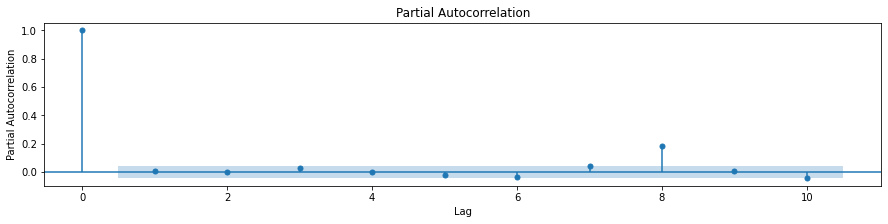

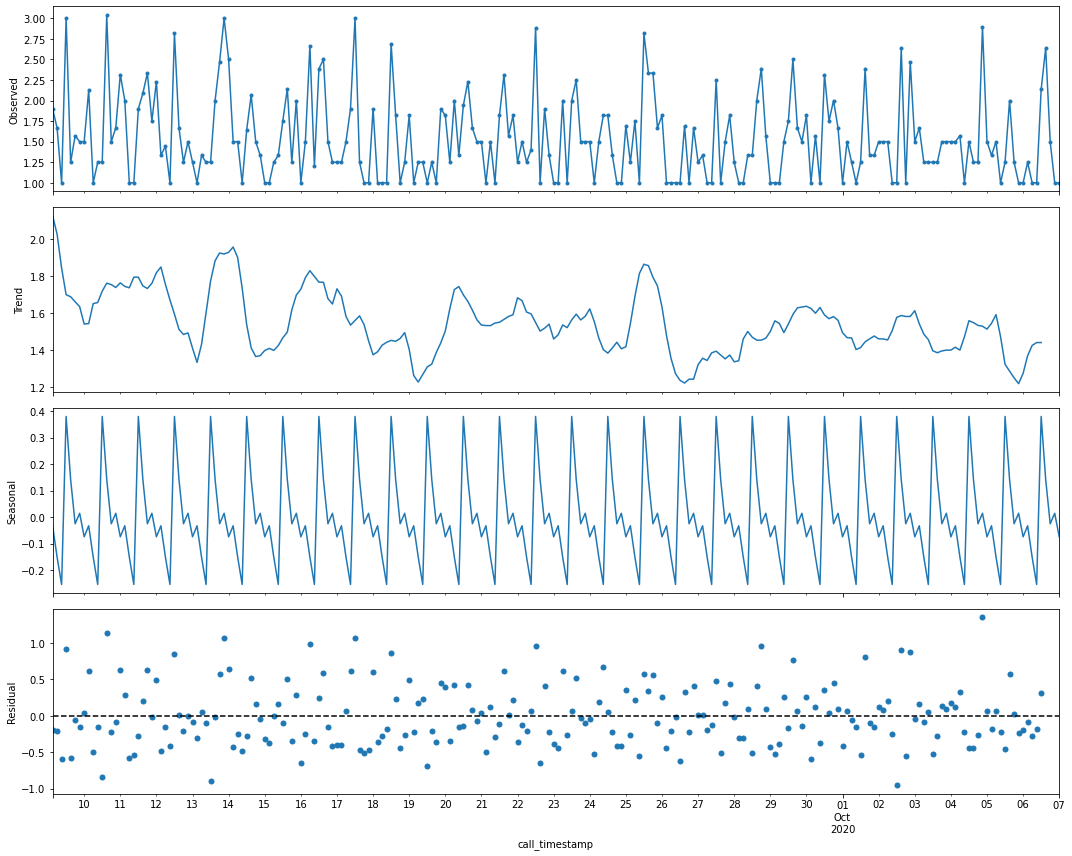

In [15]:
################################################3
# Inpsect 1 neighborhood
index = 7 # neighborhood index
# PARTIAL CORRELATION
get_pacf(att_level.data.iloc[:,index], max_lag=10)
# time series DECOMPOSITION
decomposition(att_level.data.iloc[:,index], lag=8, show=0.1)

<h4 style="text-align: center"><b>Forecast horizon</b></h4>
<p style="text-align: center">Before continuing, it is import to define now the forecast horizon (fh) that the model is intended to be used. In this case, I plan to use the model to make a 1-day forecast. With the data being grouped by 3-hour intervals, <br><b>fh = 8</b><br> is equivalent to 1 day forecast.</p>

In [16]:
# ***FORECAST HORIZON***
fh = 8 # 8 data points (i.e. 1 day) into the future
#***********************************************
# train-validation-test split
att_level.ts_split(test_size=0.1, val_size=0.1, plot=False, train_show=0.05)
# Convert to tabular
att_level.TsToTabular(lag=8)
# Train-test-split tabular format
att_level.tabular_split(test_size=0.1, val_size=0.1)

Train shape:	 (1814, 207)
Validation shape:	 (202, 207)
Test shape:	 (225, 207)


<h1> Explain clearly the choice of train-test-split and how forecast are made (need diagram).</h1>
<img src="pictures/model_evaluation.jpg" width="300" class="center">

<h1><b>NEED TO ESTABLISH A BASELINE METRICS. e.g. a naive forecasting</b></h1>

Simply forecast using the last value of the time series.

In [ ]:
# naive forecasting on validation set
pred_valid = np.full((fh), att_level.train[-1])
print("Naive validation sMAPE: ", sMAPE(pred_valid, att_level.validation))
# naive forecasting on test set
pred_test = np.full((fh), att_level.remain[-1])
print("Naive test sMAPE: ", sMAPE(pred_test, att_level.test))

<h3>1.2. SARIMAX model (univariate)</h3>

In [ ]:
# Find best model for each neighborhood.
# (p,d,q) search range
p_range = (8, 9) # only use 8 as shown best lag
d_range = (1, 4)
q_range = (1, 7)
# loop through each neighborhoods
num_nhoods = att_level.train.shape[-1]
for i in range(1, num_nhoods):
    print(f"Neighborhood {i+1} of {num_nhoods}")
    # find best arima p,d,q hyper-parameters
    arima = arima_best(fh=fh, 
                        train=att_level.train.iloc[:,i], 
                        val=att_level.validation.iloc[:,i],
                        p_range=p_range,
                        d_range=d_range,
                        q_range=q_range)
    # write the model to file with neighborhood FID in filename
    fid = att_level.get_FID_from_index(i)
    arima.save(f"models/arima_FID{fid}.pickle")

In [ ]:
# MAKING PREDICTION
# Load a model
fid = "90" # load model for neighborhood FID=1
arima = sm.load_pickle(f"models/arima_FID{fid}.pickle")
pred = arima.forecast(steps=len(att_level.test.iloc[:,81]))
print("Test sMAPE: ", round(sMAPE(att_level.test.iloc[:,81], pred), 2))

In [ ]:
# PLOT the fit
plt.figure(figsize=(8,3))
plt.plot(att_level.test.iloc[:,81], c="red", label="test", marker='o')
plt.plot(pred, c="blue", label="predict", marker='o')
plt.legend()
plt.show()

<h3>1.3. RandomForrestRegressor (univariate)</h3>

Note: Better models obtained when tuning using the <b>model_evaluation()</b> function with <b>MAPE</b> as the loss.

In [ ]:
# Find best model for each neighborhood
# set max_depth
max_depth = int(np.sqrt(att_level.X_train.shape[0]))
max_n_estimator = 400
# loop through each neighborhoods
num_nhoods = len(att_level.neighborhoods)
for i in range(0, num_nhoods):
    print(f"Neighborhood {i+1} of {num_nhoods}")
    # find best random forest regressor hyper-parameters
    rfr = rand_forest_reg_best(X_train=att_level.X_train[:,:,i],
                                y_train=att_level.y_train[:,i],
                                X_test=att_level.X_validation[:,:,i],
                                y_test=att_level.y_validation[:,i],
                                max_n_estimator=max_n_estimator,
                                max_depth=max_depth,
                               fh=fh)
    # write the model to file with neighborhood FID in filename
    fid = att_level.get_FID_from_index(i)
    joblib.dump(rfr, f"models/forest_FID{fid}.pickle")

In [ ]:
# MAKING PREDICTION
# Load a model
index = 0
fid = att_level.get_FID_from_index(index) # load model for neighborhood FID=1
rfr = joblib.load(f"models/forest_FID{fid}.pickle")
# predict test
start = 0 # start index
y = att_level.y_test[start:(start+fh), index]
pred = recursive_forecast(model=rfr,
                          X=att_level.X_test[:,:,index], 
                          start=start, 
                          fh=fh,
                          input_3d=False)
print("MAPE: ", MAPE(pred, y))
# plot
plot(data=[y, pred],
     labels=["test", "prediction"])

<h3>1.4. Dense Neural Network (univariate)</h3>

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
# Find a number of hidden layers for the models.
# Using one neighborhood as example.
# It is too time consuming to optimize number of hidden layers
# for all 207 neighborhoods.
index = 0 # choose neighborhood with index=0
dnn, history = dense_nn_best(X_train=att_level.X_train[:,:,index], 
                             y_train=att_level.y_train[:,index],
                             X_val=att_level.X_validation[:,:,index],
                             y_val=att_level.y_validation[:,index],
                             max_hidden_layers=6,
                             nodes_per_hidden=500,
                             output_nodes=1,
                             flatten=False)

In [ ]:
# Check for overfitting
loss = pd.DataFrame.from_dict(history.history)
loss[["loss", "val_loss"]].plot(figsize=(10,4));
loss[["sMAPE_tensor", "val_sMAPE_tensor"]].plot(figsize=(10,4));

Note: It appears that between 2-6 hidden layers, 3 hidden layers give the best result. The loss of validation set is about the same to that of train set, which indicates there is not overfitting. Therefore, network of 3 hidden layers will be used for all neighborhoods.

In [ ]:
# BUILD MODEL FOR EACH NEIGHBORHOOD
# fit a model to each neighborhood.
for i in range(0, num_nhoods):
    print(f"Neighborhood {i+1} of {num_nhoods}", end="\r")
    input_shape= att_level.X_train[:,:,i].shape[1:]
    dnn = build_dnn(num_hidden_layers=3,
                    nodes_per_hidden=500,
                    num_output_nodes=1,
                    input_shape=input_shape, 
                    flatten=False) # univariate, no flatten needed
    # Compile the model
    dnn.compile(loss="mse", optimizer="adam")
    # Fit the model
    history = dnn.fit(att_level.X_train[:,:,i], 
                        att_level.y_train[:,i],  
                        epochs=50,
                        verbose=0)
    # write the model to file with neighborhood FID in filename
    fid = att_level.get_FID_from_index(i)
    dnn.save(f"models/dnn_uni_FID{fid}.h5")

In [ ]:
# MAKING PREDICTION
# Load a model
index = 0
fid = att_level.get_FID_from_index(index) # load model for neighborhood FID=1
dnn = 
# predict test
pred = recursive_forecast(dnn, att_level.X_test[:,:,0], 0, fh, input_3d=False)
true = att_level.y_test[:fh,0]
print(MAPE(pred, true))
plot(data=[pred, true], labels=["pred", "true"])

<h3>1.4. Dense Neural Network (Multivariate)</h3>

<h3>1.4. Recurrent Neural Network</h3>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN, LSTM, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD

In [ ]:
num_nhoods = att_level.X.shape[-1]
rnn = Sequential()
'''
# layer 1
rnn.add(SimpleRNN(1024, return_sequences=True, input_shape=[None, 1]))
rnn.add(Dropout(0.2))
rnn.add(BatchNormalization())
# layer 2
rnn.add(SimpleRNN(612, return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(BatchNormalization())
# layer 3
rnn.add(SimpleRNN(306, return_sequences=True))
rnn.add(Dropout(0.2))
rnn.add(BatchNormalization())
# layer 4
rnn.add(SimpleRNN(32, return_sequences=True))
rnn.add(Dropout(0.1))
rnn.add(BatchNormalization())
# layer 5
rnn.add(SimpleRNN(1))
'''
# layer 1
rnn.add(LSTM(1024, return_sequences=True, input_shape=[None, num_nhoods], activation="relu"))
rnn.add(Dropout(0.2))
rnn.add(BatchNormalization())
# layer 2
rnn.add(LSTM(612, return_sequences=True, activation="relu"))
rnn.add(Dropout(0.1))
rnn.add(BatchNormalization())
# layer 2
rnn.add(LSTM(153, activation="relu"))
rnn.add(Dropout(0.1))
rnn.add(BatchNormalization())
# layer 3
rnn.add(Dense(num_nhoods, activation="relu"))
rnn.summary()

In [ ]:
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False, clipnorm=2.0)
rnn.compile(
    loss="mean_squared_error",
    optimizer=sgd
)
# Add one more axis to data
#X = att_level.X_remain[..., np.newaxis]
X = att_level.X_remain
#y = att_level.y_remain.reshape(-1,1)
y = att_level.y_remain
history = rnn.fit(X, y, epochs=500)

In [ ]:
loss = pd.DataFrame(history.history)
loss.plot(marker="o");

In [ ]:
# SAVE THE MODEL THE LOSS
rnn.save("models/rnn_multi_v1.h5")
loss.to_csv("models/rnn_multi_v1_loss.csv", header=True)

In [ ]:
# predict test
data = att_level.test
fh = len(data)
pred = recursive_forecast(rnn, att_level.X, start=-fh, fh=fh, input_3d=True)
# convert back to ts
pred = pd.DataFrame(pred, index=data.index, columns=data.columns)
print(sMAPE(pred, data))
# plot
plot(data=[att_level.remain.iloc[:,8][-50:], data.iloc[:,8], pred.iloc[:,8]],
     labels=["remain", "test", "prediction"])

In [ ]:
sMAPE(pred.iloc[:,0], att_level.test.iloc[:,0])

<hr>
<h1 style="text-align: center;">Attention level heatmap</h1>

In [ ]:
import folium
def detroit_heatmap(data, geo_json):
    '''
    data: dataframe
            Data to be plot. Columns: FID: neighborhood id
                                      data: data to be plot
    '''
    # link to geojson
    lat = 42.365753
    lng = -83.076760
    detroit_map = folium.Map(location=[lat, lng], zoom_start=11)
    detroit_map.choropleth(
        geo_data = geo_json,
        data = data,
        columns = ["FID", "att_level"],
        key_on = "properties.FID", # match geojson FID with data FID
        threshold_scale = [0, 0.4, 0.8, 1.2, 1.7, 2.1, 2.5],
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        reset=True,
        legend_name="Attention level"
    )
    #title_html = '''
    #             <h3 align="center" style="font-size:20px"><b>Your map title</b></h3>
    #             '''
    #detroit_map.get_root().html.add_child(folium.Element(title_html))
    display(detroit_map)

In [ ]:
# read in Detroit neighborhood geojson.
import json
with open("data/detroit_geo.json") as json_file:
    detroit_geo = json.load(json_file)

In [ ]:
#data = att_level.data.iloc[-9:-1,:]
data = pred
for i in range(data.shape[0]):
    df = pd.DataFrame(data.iloc[i,:]).reset_index()
    df.columns = ["FID_name","att_level"]
    df["FID"] = df["FID_name"].apply(lambda x: x.split(",")[0])
    df["FID"] = df["FID"].astype("int32")
    detroit_heatmap(df, detroit_geo)

<hr>
<h1 style="text-align: center;">Using different loss metrics</h1>

<b>Note: when using sMAPE as the loss function, the model tend to just predict the average instead of following the data like when using mse as loss function. I suppose guessing the average give low error too. It could very likely be that sMAPE is less sensitive at large % than small %, hence when sMAPE get small, the model doesn't know that small changes in sMAPE are even more significant.</b><br>
mse, mean loss: 8.6%
sMAPE, mean loss: 7.8%

<hr>
<h1 style="text-align: center;">Models comparison</h1>

<h2>1. Performance in term of loss</h2>
<h2>2. Training time</h2>
<h2>3. Univariate vs multivariate</h2>
<p>
    Due to the amount of models (207) needed to be optimized when using univariate approach. Careful attention about overfitting and underfitting were not possible. The models were only optimized for minimum validation loss.
</p>

<hr>
<h1 style="text-align: center;">Multiple-variate vs multivariate</h1>

<hr>
<h1 style="text-align: center;">Notes</h1>

<ul>
    <li>Demographics bias was raised about this kind of forecasting approach. Therefore should overlay this time-series forecasting here with demographic information of Detroit.</li>
</ul>

<hr>
<h1 style="text-align: center">Additional study</h1>

<h2>Tweets</h2>

<b>CLEANING NOTES</b>
<ul>
    <li>Remove duplicated tweets.</li>
    <li>Drop tweets WITHOUT GPS tag.</li>
    <li>Separate <code>coordinates</code> into longitude and latitude</li>
    <li>Label tweets with neighborhood FID and name</li>
    <li>Drop tweets not in Detroit's neighborhoods.</li>
    <li>Drop columns not relevant to this study.</li>
    <li><code>created_at</code> need to be <code>datetime64</code></li>
    <li>Filtered out tweets generated by bots, advertising, or traffice notification.</li>
</ul>

In [ ]:
# Process raw tweets csv files.
files = [f"data/tweet{i}.csv" for i in range(7)]
data_proc.process_tweets(files)

In [ ]:
tweets = pd.read_csv("data/tweets_cleaned.csv")
tweets["created_at"] = tweets["created_at"].astype("datetime64")
tweets.set_index("created_at", inplace=True)

<h3>EDA</h3>

In [ ]:
tweets.info()

In [ ]:
# Tweet sources
tweets["source"].value_counts(normalize=True)

In [ ]:
#plt.figure(figsize=(7,5))
#plt.scatter(tweets["lng"], tweets["lat"], s=1, c="r", alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
for neighbor in detroit.boundaries.values():
    plt.plot(*neighbor.exterior.xy, lw=1, c="b", alpha=0.5)
plt.show()

In [ ]:
# Entire city tweets time series
city_tweets_ts = data_proc.time_groupby(tweets, "id_str", freq="180Min")
plt.figure(figsize=(15,3))
city_tweets_ts.sum(axis=1).plot()
plt.show()

In [ ]:
# Tweets ONE neighborhood
# selected neighborhood
nhood = "19,Warrendale"
nhood_ts = data_proc.time_groupby(tweets, 
                                  col="id_str",
                                  agg="count",
                                  nhoods=[nhood],
                                  freq="1440Min")
plt.figure(figsize=(15,3))
nhood_ts.iloc[-160:].plot()
plt.show()

Note that the amount of tweets in a neighborhood is very low. This is like due to the fact that only a very small portion of Twitter users actually have their geo-tagged feature enable. Therefore, it appears that tweets count can not be used in analysis.

In [ ]:
%lsmagic